<a href="https://colab.research.google.com/github/sara81278/ENN/blob/main/DCT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
from skimage import data
import matplotlib.pyplot as plt
import numpy as np
from scipy.fftpack import dctn, idctn
import random

## Discete Cosine Transform
Assume a set of function values $y_n$ for $n=0,\dots, N-1$, the Type-II Discrete Cosine Transform (DCT) is defined as:
\begin{equation}
B_p = \alpha_p\sum_{n=0}^{N-1} A_n \cos\left(\frac{\pi k(2n+1)}{2N}\right)\quad \text{for} \quad p=0,\dots, N-1
\end{equation}

where $\alpha_k=1/\sqrt N$ for $k=0$ and $\alpha_k=\sqrt{2/N}$ otherwise.
We call the $A_n$ the *function values* and the $B_p$ the **DCT coefficients**.

The invese operation of the DCT as defined above is the following:
\begin{equation}
A_n = \sum_{p=0}^{N-1} \alpha_p B_p \cos\left(\frac{\pi (2n+1)p}{2N}\right)\quad \text{for} \quad n=0,\dots, N-1
\end{equation}
which, essentially, allows the reconstruction of the $A_n$ exploiting the DCT coefficients $B_p$.

### DCT util functions

In [19]:
def my_dctn(block, with_alpha = False):
  '''
  Implementation of dctn, it can handle up to 2-dimensions.
     block: either a 2-dimensional image_block or a 1-dimensional array representing a function f(x)
  '''

  if(len(np.shape(block)) == 1):
    block = np.reshape(block, (np.shape(block)[0], 1))

  M, N = np.shape(block)
  B = np.zeros((M, N))
  for p in range(M):
    alpha_p = 1/np.sqrt(M) if p == 0 else np.sqrt(2/M)
    cos_coef_p = np.pi * p /(2*M)
    for q in range(N):

      alpha_q = 1/np.sqrt(N) if q == 0 else np.sqrt(2/N)
      cos_coef_q = np.pi * q /(2*N)

      B_p_q = alpha_p*alpha_q*np.sum(
          [np.sum(
              [block[m,n]*np.cos(cos_coef_p*(2*m+1))*np.cos(cos_coef_q*(2*n+1)) for n in range(N)]
              ) for m in range(M)]
          )
      B[p, q] = np.round(B_p_q,8)

  if(not with_alpha): # whether the alpha is 'absobed' by the coefficients
    B[p, :] *= alpha_p
    B[:, q] *= alpha_q

  if(np.shape(block)[1] == 1):
    B = np.reshape(B, (M,))
  return B

In [20]:
def my_idctn(B, with_alpha = False):
  '''
  Implementation of one-dimentional idctn
    B : DCT coefficients
  '''
  N = len(B)
  A_n = np.zeros(N)
  for n in range(N):
    alpha_q = np.concatenate(([np.sqrt(1/N)], np.ones(N-1)*np.sqrt(2/N)))
    cosines = np.cos(np.pi*np.arange(N)/(2*N)*(2*n+1))
    if(not with_alpha):
      A_n[n]= round(B @ cosines, 8)
    else:
      A_n[n]= round(alpha_q*B @ cosines, 8)
  return A_n

In [21]:
def function_eval(x, function='sin', f_mod=0.25):
  """
  This function evaluates a vector for a given function.

  Parameters
  ----------
  x : ndarray
      Input array.
  function : string
      Name of the function to be computed. Choose among:
        - linear: y(x) = x
        - sine: y(x) = sin(pi*x/2)
        - compander: y(x) =
        - square: y(x) = sign(x) * x**2
        - sqrt: y(x) = sign(x) * sqrt(abs(x))

  Returns
  -------
  y : ndarray
      The function values.
  """
  N = len(x)
  #x_s = x[:int(N/2)]
  if function == 'linear':
      y = f_mod * ( x - (N-1)/2 - 1 )
  elif function == 'sin':
      y = (f_mod*N/2) * ( np.sin( np.pi*x/N - np.pi/2 ) - 0.5*2/N ) #
      #y = np.hstack(( y_b, np.flip(-y_b) ))
  elif function == 'sigmoid':
      mu = -0.5 * N/2
      y_left = (f_mod*N/2) * ( 1 - np.exp( -(f_mod/mu)*x[:int(N/2)] )) / ( 1 - np.exp( -f_mod*N/(2*mu) ))
      y_right = np.flip(-y_left) + f_mod*N
      y = np.hstack(( y_left, y_right )) - f_mod*N/2
  elif function == 'square':
      y_right = f_mod**2/(2*np.sqrt(N)) * x[:int(N/2)]**2
      y = np.hstack(( np.flip(-y_right), y_right ))
  elif function == 'sqrt':
      y_right = N/8 * np.sqrt( x[:int(N/2)]/x[int(N/2)] )
      y_left = -np.flip(y_right)
      y = np.hstack(( y_left, y_right ))
  #TBD
  elif function == 'poly':
      y = 0.01*x**4 + 0.1*x**3 - 0.02*x**2
  elif function == 'exp':
      y = np.exp(x)
  elif function == '-exp':
      y = -np.exp(x)
  elif function == 'floor':
      y = np.floor(x)
  elif function == 'abs':
      y = np.abs(x)
  elif function == 'sign':
      y = np.sign(x)
  else:
      print("Function not available. Sine function assumed.")
      y = np.sin(x)
  return y

ALL_COEFFS = 256

def function_select(function='sin', N=ALL_COEFFS, f_mod=1):
  """
  This function creates a the function values for a given interval and number
  of samples.

  Parameters
  ----------
  function : string
      Name of the function to be computed.
  N : int
      The number of samples.
  f_mod : int or real
      Spreading factor of the chirp signal

  Returns
  -------
  x : ndarray
      The interval of x values.
  y : ndarray
      The function values.

  """
  x = np.arange(1, N+1)
  y = function_eval(x, function, f_mod)
  return x, y


In [22]:
def compact_coefficients_number(B, energy_percentage = 0.9997):
  '''
  This function computes the minimum number of coefficient we need to retain at least energy_percentage% of the total energy
    B: dctn coefficients
  '''
  total_energy = np.sqrt(np.sum(B**2))
  for i in range(0, len(B)):
    energy = np.sqrt(np.sum(B[:i+1]**2))
    if(energy >= energy_percentage*total_energy):
      return i+1

In [23]:
def MSE_pratico(f, f_hat):
  'Mean Squared difference between the true function and its approximation'
  return np.mean((f-f_hat)**2)

def NMSE_pratico(f, f_hat):
  'Normalized Mean Squared difference between the true function and its approximation'
  return MSE_pratico(f, f_hat)/np.mean(f**2)

def MSE_teorico(dct_coeff, Q):
  'Mean Squared Error that is obtained when we retain only Q dct coefficients'
  return np.mean(dct_coeff[Q:]**2)

def NMSE_teorico(f, dct_coeff, Q):
  'Normalized MSE that is obtained when we retain only Q dct coefficients'
  return MSE_teorico(dct_coeff, Q)/np.mean(f**2)

def MSE_energy_percentage(dct_coeff, alpha):
  ''' Mean Squared Error that is obtained when we retain alpha% of the total energy'''
  total_energy = np.sqrt(np.sum(dct_coeff**2))
  return (1-alpha)/len(dct_coeff)*total_energy

def NMSE_energy_percentage(f, dct_coeff, alpha):
  ''' Normalized Mean Squared Error that is obtained when we retain alpha% of the total energy'''
  return MSE_energy_percentage(dct_coeff, alpha)/np.mean(f**2)

In [24]:
def odd_sqrt(x):
  'Computes the odd square root, with mean 0'
  N = max(x)
  N_samples = len(x)
  y_sqrt = np.zeros(N_samples)

  for i in range(N_samples):
    if x[i]> N/2:
      y_sqrt[i] = (N/2)*np.sqrt(2*(x[i]-N/2)/N)
    else:
      y_sqrt[i] = -(N/2)*np.sqrt(-2*(x[i]-N/2)/N)
  return y_sqrt

def odd_sin(x):
  'Computes the odd sin function, with mean 0'
  N = max(x)
  y_sin = N/2 * np.sin(np.pi * (x-N/2)/N)
  y_sin -= np.mean(y_sin)
  return y_sin

def odd_cosine(x):
  N = max(x)
  y_cosine = np.cos(np.pi * (x-N)/N)*N/2
  y_cosine -= np.mean(y_cosine)
  return y_cosine

## Appoximating function with DCT
Given a discrete signal $A_n$, one can define the energy of that signal as the total magnitude of its DCT coefficient, defined as following:

\begin{equation}
E_T = \sqrt{\sum_{p=0}^{N-1}|B_p|^2}
\end{equation}

The DCT has a storng enegy compaction property, which means that the magnitude of the coefficients decreases rapidly and not all of them are needed to retain a certaint level of energy (and hence a certain level of recostruction).

Assume that the coefficients are ordered in increasing energy, this is, $|B_i|\geq|B_j|, 0\leq i\leq j\leq N-1$. Given the percentage of energy to be kept $\alpha$ (e.g., $\alpha=0.997$), the number of parameters to be kept is:

\begin{equation}
Q = argmin_q \Bigl\{  q\in\mathbb{N}^+\,\Big|\, \sqrt{\sum_{k=0}^{q-1}|B_k|^2}\leq\alpha E_T  \Bigr\}\quad
\end{equation}

As shown in the following plots, the approximation of the linear function is very close to the true function using only 10 DCT coefficients  (99.99% energy retained).

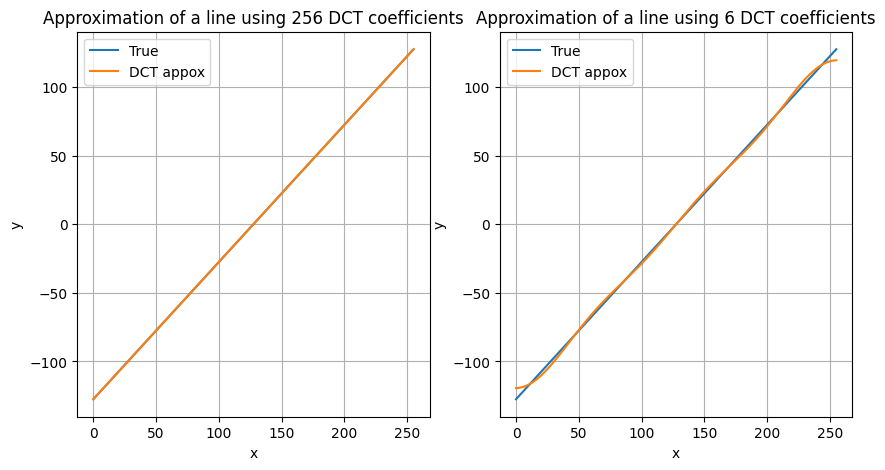

In [25]:
N=256
x = np.arange(0, N)
y = x-np.mean(x)
dct_coeff = dctn(y, type = 2, norm = 'ortho')

fig, axes = plt.subplots(1,2, figsize = (10, 5))

axes[0].plot(x,y, label ='True')
axes[0].plot(my_idctn(dct_coeff, with_alpha=True), label='DCT appox')
axes[0].set(xlabel = 'x', ylabel = 'y', title = f'Approximation of a line using {len(dct_coeff)} DCT coefficients')
axes[0].legend()
axes[0].grid(True)

dct_coeff[6:] = 0

axes[1].plot(x,y, label ='True')
axes[1].plot(my_idctn(dct_coeff, with_alpha=True), label='DCT appox')
axes[1].set(xlabel = 'x', ylabel = 'y', title = f'Approximation of a line using 6 DCT coefficients')
axes[1].legend()
axes[1].grid(True)

plt.show()

Since the base functions of the DCT are orthogonal, the **MSE** between the true function $y$ and its approximation using DCT coefficients $\hat{y}$ is the complement of the retained energy, i.e., the energy of the discarded coefficients:
\begin{equation}
MSE(y, \hat{y}) = \sum_{q=Q+1}^N |B_q|^2
\end{equation}

As demonstrated by the following plots, the DCT provides an effective approximation for various functions. In general, a good approximation of the original function (i.e., low NMSE) can be achieved by retaining only a small number of coefficients. For instance, **retaining 99.99% of the energy** of a sine function over a small period requires just two DCT coefficients.

On the other hand, to retain the same amount of energy in the approximation of the **sigmoid** function, requires the need of nearly all the DCT coefficients. This is due to the rapid changes of the sigmoid, especially around its midpoint, which makes it challenging for the DCT to efficiently compress.

In geneal, sharp changes in a function lead to what is known as the **Gibbs phenomenon**: this occurs when a finite number of DCT coefficients is used to approximate a function with such a characteristic. As a result, oscillations appear near the points of steep change, and more coefficients are needed to reduce the approximation error.

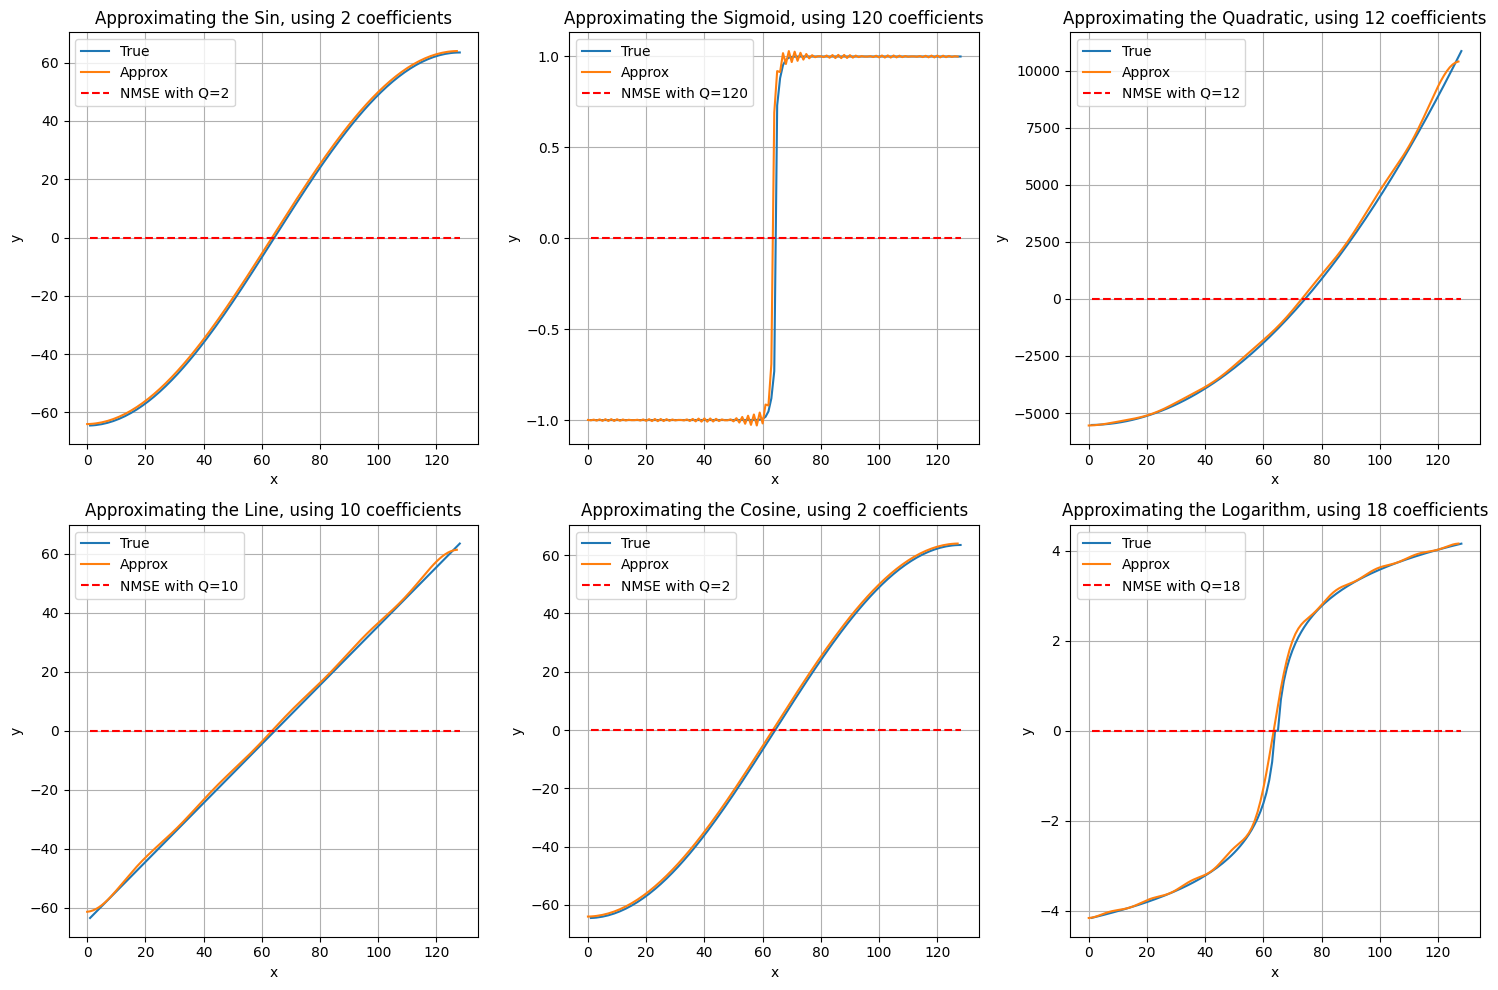

In [26]:
# Create 3x3 subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

functions = [odd_sin, lambda z:1/(1 + np.exp(-z)), lambda x: x**2-np.mean(x**2), lambda x:x-np.mean(x), odd_cosine, np.log]
function_names = ['Sin', 'Sigmoid', 'Quadratic', 'Line', 'Cosine', 'Logarithm']
N=128

energy_to_retain = 0.9999

for i in range(2):
    for j in range(3):
        ax = axes[i, j]
        func_index = i * 3 + j  # Calculate the function index
        if func_index < len(functions):

          #True function
          x = np.arange(1, N+1)
          y = functions[func_index](x)
          if(function_names[func_index] in ['Logarithm', 'Sigmoid']):
            y = np.concatenate((np.flip(-y[0:int(N/2)]), y[0:int(N/2)]))

          ax.plot(x, y, label='True')

          #Approximation
          dctn_coefficients = dctn(y, type = 2, norm = 'ortho')
          Q = compact_coefficients_number(dctn_coefficients, energy_to_retain)
          dctn_coefficients[Q:] = 0
          y_hat = idctn(dctn_coefficients, type = 2, norm = 'ortho')
          ax.plot(y_hat, label='Approx')

          #NMSE lines
          mse = NMSE_pratico(y, y_hat)
          ax.plot(x, np.ones(len(x))*mse, label=f'NMSE with Q={Q}', linestyle='--', color='red')
          ax.set(xlabel = "x", ylabel = "y", title = f"Approximating the {function_names[func_index]}, using {Q} coefficients")
          ax.legend()
          ax.grid(True)
        else:
          ax.set_title(f"Function {function_names[func_index]}")
        ax.grid(True)

plt.tight_layout()
plt.show()

## Learning DCT coefficients through Least Mean Square Error

If we have access to enough data, instead of computing the DCT coefficients directly, it's possible to learn it through an adaptive filter, like Least Mean Square (**LMS**).

Least Mean Square is an adaptive filter that minimizes the **mean square error** between the true function and the one we are trying to approximate. Therefore, the coefficients are updated, for each sample $x$ in the batch, in the following fashion:

\begin{equation}
B_p = B_p - \mu \cdot \frac{\delta \epsilon}{\delta B_p}
\end{equation}

In the above equation, $\mu$ is called learning rate and it's equal to $\mu = \frac{4 \alpha }{Q}$, where Q is the number of retained coefficients (a simple hyperparameter) and $\alpha$ is the error percentage allowed.


From a theoretical point of view, convergency to an approximation that yields an error percentage $\alpha$ should be reached after $\frac{-ln(\alpha) Q}{2\alpha}$ samples.


In [27]:
def LMSE(x_batch, y_true, N, Q, B_p_hat, alpha = 0.01, true_function = odd_sqrt):
  '''
  Least Mean Squared Error
    x_batch = batch
    y_true = f(x_batch)
    N = function domain
    Q = number of coefficients to retain
    B_p_hat = starting coefficients
    alpha = percentage of error we allow
    true_function = function to approximate, needed to compute the theoretical MSE_min and misadjustment
  '''

  mu=4*alpha/Q

  N_samples = len(x_batch)
  B_p_hat[2*Q:] = 0

  mse_history = []
  B_hat_history = []

  # For each point i, compute the error at point i using Q coefficients and then update the coefficients
  for i in range(N_samples):
    #Compute the error at point i
    y_hat = 0
    for q in range(Q):
      cosine_coefficient = np.pi*(2*q+1)/(2*N)
      x_n = np.cos(cosine_coefficient*(2*x_batch[i]+1))
      idct_i = B_p_hat[2*q+1]*x_n
      y_hat += idct_i

    error_i = y_true[i]- y_hat
    mse_history.append(error_i**2)

    #Update the coefficients
    for q in range(Q):
      B_p_hat[2*q+1] += mu*error_i*np.cos(np.pi*(2*q+1)/(2*N)*(2*x_batch[i]+1))

    B_hat_history.append(B_p_hat)

  convergency_rate = -np.log(alpha)*Q/(2*alpha) ## After how many samples we converge
  if(N_samples > convergency_rate):
    print(f'Convergency rate: {np.ceil(convergency_rate)} samples')
    error_misured = np.mean(mse_history[int(convergency_rate)+1: ]) # MSE at convergence
    error_misured = np.round(error_misured, 4)
    print(f'Error misured: {error_misured}')

    mse_min = MSE_teorico(dctn(true_function(np.arange(N)), type=2, norm='ortho'), 2*Q) ## in theory, the MSE min that can be obtained it's equal to the magnitude of coefficients not kept
    mse_min = np.round(mse_min, 4)

    print(f'Misadjustment: {np.round( 100*np.abs(error_misured-mse_min)/(2*mse_min), 4)}%, mse minimo {mse_min}')

  if(N_samples < convergency_rate):
    print(f'Sample size too small to reach desired convergence. Theoretical convergence is expected after {np.ceil(convergency_rate)} samples')
  return (B_p_hat, mse_history)

In [28]:
N = 128
N_samples = 10000
#Creating the dataset
x = np.random.randint(0,N,N_samples)
alpha = np.concatenate(([1],np.sqrt(2)*np.ones(len(x)-1)))/np.sqrt(len(x))
# Starting point
y_linear = x-np.mean(x)
dctn_linear = dctn(y_linear, type = 2, norm = 'ortho')*alpha

#### Approximating Sin function with LMSE

To approximate the sine function using the Least Mean Square Error (LMSE) approach, different initialization techniques for the DCT coefficients $B_p$ can be used. In this case, the DCT coefficients of a linear function are chosen as the initial values.

Starting from the same sample, approximation is performed using $\alpha \in \{0.01, 0.0001\}$.

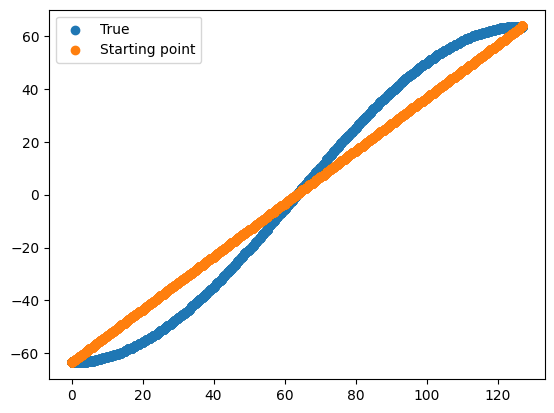

In [29]:
#Function to approximate
y_sin = odd_sin(x)

plt.scatter(x, y_sin, label = 'True')
plt.scatter(x, my_idctn(dctn_linear), label ='Starting point')
plt.legend()
plt.show()

At convergence, the misured error is very close to $\alpha$, which means that the algorithm successfully learned the coefficients with low error, yielding a good function approximation.

Convergency rate: 1382.0 samples
Error misured: 0.0079
Misadjustment: 3900.0%, mse minimo 0.0001


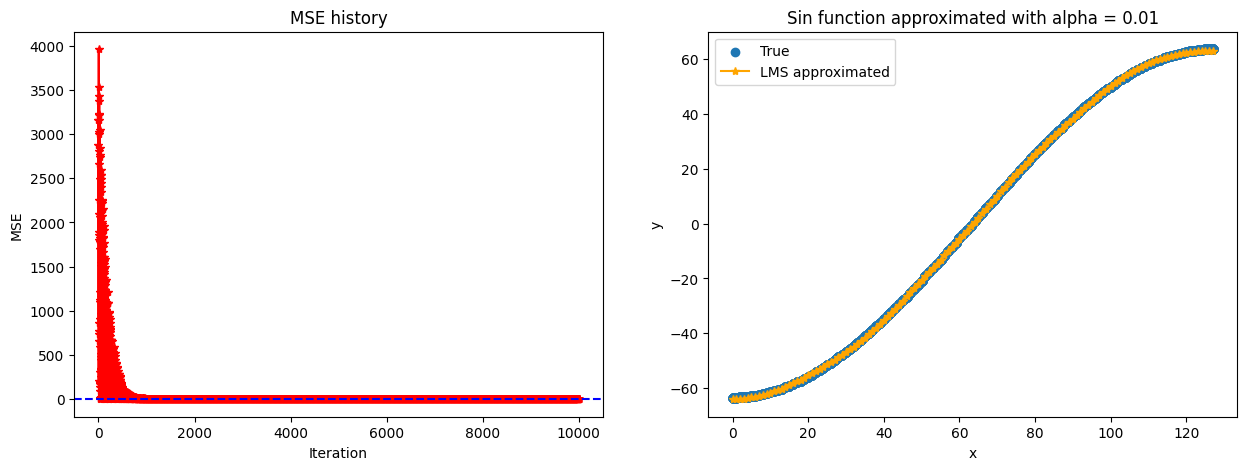

In [30]:
Q = 6
alpha = 0.01
B_p_hat = dctn_linear.copy()
B_p_hat, mse_history = LMSE(x, y_sin, N, Q, B_p_hat, alpha = alpha, true_function = odd_sin) # approximate the sin starting from dctn coefficients of the linear function
fig, axes = plt.subplots(1,2, figsize=(15,5))
axes[0].plot(mse_history, '*-', color='red')
axes[0].set_title('MSE history')
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('MSE')
axes[0].axhline(y=alpha, color='blue', linestyle='--', label='alpha')

axes[1].scatter(x, y_sin, label ='True')
axes[1].plot(my_idctn(B_p_hat[:128]), '-*', label ='LMS approximated', color = 'orange')
axes[1].set_title(f'Sin function approximated with alpha = {alpha}')
axes[1].set_xlabel('x')
axes[1].set_ylabel('y')
axes[1].legend()
plt.legend()
plt.show()

Lowering the hyperparameter $\alpha$, should theoretically lead to finer adjustments and a lower approximation error. However, here the coefficients could not be effectively learned: this is due to the fact that the data are not sufficient to guarantee convergence. For such a small error percentage, the required theoretical sample should be of size at least 200k.

Without enough data, the algorithm cannot learn the coefficients and this yields to a poor function approximation, as evident from the plots.



Sample size too small to reach desired convergence. Theoretical convergence is expected after 276311.0 samples


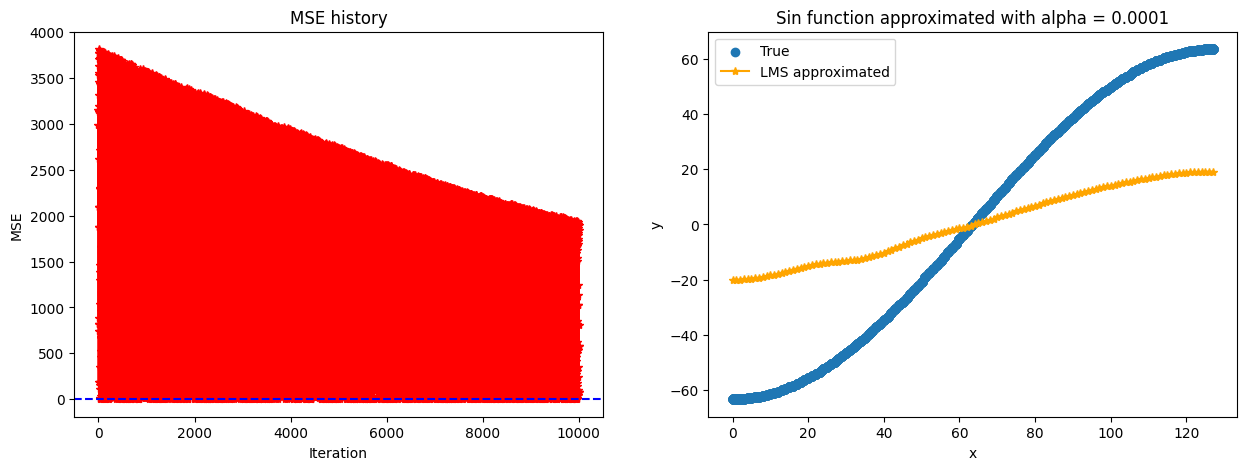

In [31]:
Q = 6
alpha = 0.0001
B_p_hat = dctn_linear.copy()
B_p_hat, mse_history = LMSE(x, y_sin, N, Q, B_p_hat, alpha = alpha, true_function = odd_sin) # approximate the sin starting from dctn coefficients of the linear function
fig, axes = plt.subplots(1,2, figsize=(15,5))
axes[0].plot(mse_history, '*-', color='red')
axes[0].set_title('MSE history')
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('MSE')
axes[0].axhline(y=alpha, color='blue', linestyle='--', label='alpha')

axes[1].scatter(x, y_sin, label ='True')
axes[1].plot(my_idctn(B_p_hat[:128]), '-*', label ='LMS approximated', color = 'orange')
axes[1].set_title(f'Sin function approximated with alpha = {alpha}')
axes[1].set_xlabel('x')
axes[1].set_ylabel('y')
axes[1].legend()
plt.legend()
plt.show()

#### Approximating sqrt function with LMSE

The same experiment here is repeated with the square root function $f(x) = \sqrt(x)$

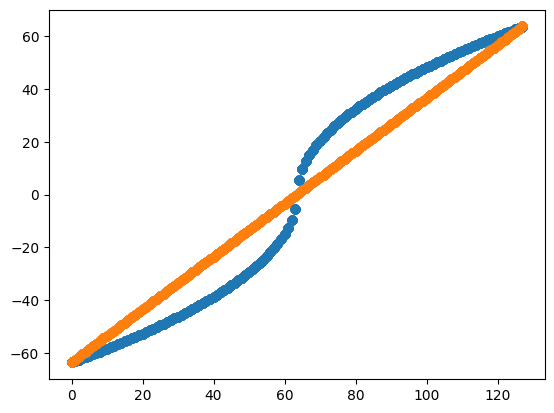

In [32]:
y_sqrt = odd_sqrt(x)
plt.scatter(x,y_sqrt)
plt.scatter(x, my_idctn(dctn_linear), label ='Starting point')

The approximation results for the square root function with $\alpha = 0.01$ are not far from the ones of the sin function. The most notable difference, is that here the number of coefficients $Q$ we choose to retain gives a minimum error of $MSE_min = 1.7$. This is might be due to the fact that the square root function has sharps changes which require more coefficients to achieve the same level of approximation accuracy.

Nonetheless, the measured error is close to the minimum error, indicating that the LMSE algorithm yields a good approximation.



Convergency rate: 1382.0 samples
Error misured: 1.6015
Misadjustment: 3.5123%, mse minimo 1.7225


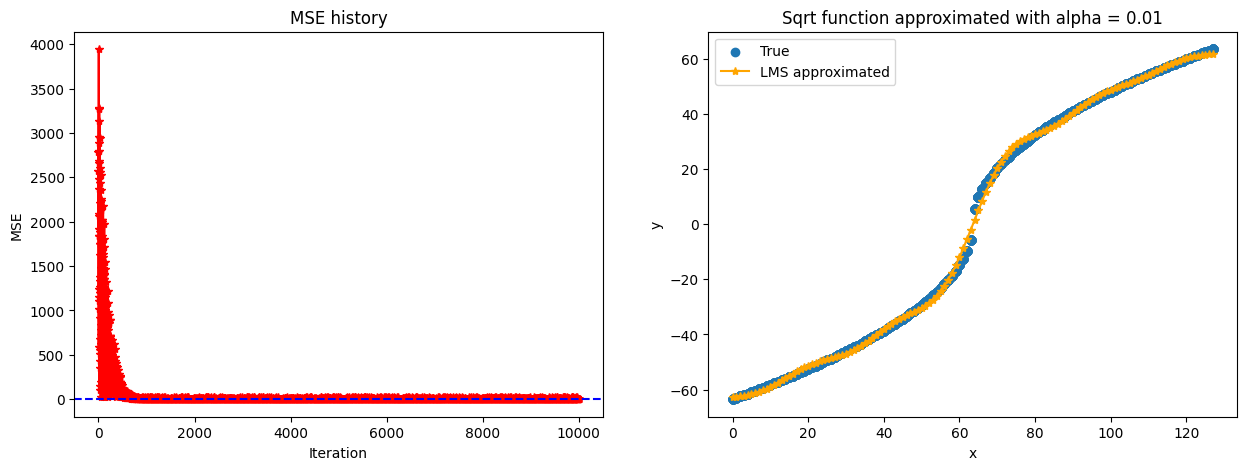

In [36]:
Q = 6
alpha = 0.01
B_p_hat = dctn_linear.copy()
B_p_hat, mse_history = LMSE(x, y_sqrt, N, Q, B_p_hat, alpha = alpha, true_function = odd_sqrt) # approximate the sin starting from dctn coefficients of the linear function
fig, axes = plt.subplots(1,2, figsize=(15,5))
axes[0].plot(mse_history, '*-', color='red')
axes[0].set_title('MSE history')
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('MSE')
axes[0].axhline(y=alpha, color='blue', linestyle='--', label='alpha')

axes[1].scatter(x, y_sqrt, label ='True')
axes[1].plot(my_idctn(B_p_hat[:128]), '-*', label ='LMS approximated', color = 'orange')
axes[1].set_title(f'Sqrt function approximated with alpha = {alpha}')
axes[1].set_xlabel('x')
axes[1].set_ylabel('y')
axes[1].legend()
plt.legend()
plt.show()

The issue observed with the sine function also arises with the square root function. In practice, the theoretical limitation (insufficient sample size to ensure convergence) becomes evident: the approximation of the square root function is very poor, and the final mean squared error MSE remains high.



Sample size too small to reach desired convergence. Theoretical convergence is expected after 276311.0 samples


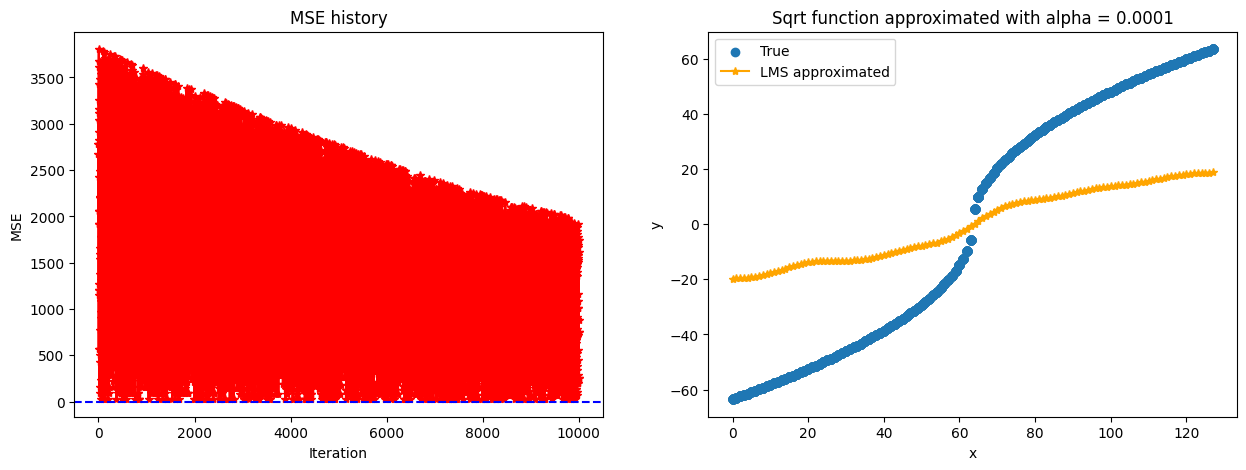

In [34]:
Q = 6
alpha = 0.0001
B_p_hat = dctn_linear.copy()
B_p_hat, mse_history = LMSE(x, y_sqrt, N, Q, B_p_hat, alpha = alpha, true_function = odd_sqrt) # approximate the sin starting from dctn coefficients of the linear function
fig, axes = plt.subplots(1,2, figsize=(15,5))
axes[0].plot(mse_history, '*-', color='red')
axes[0].set_title('MSE history')
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('MSE')
axes[0].axhline(y=alpha, color='blue', linestyle='--', label='alpha')

axes[1].scatter(x, y_sqrt, label ='True')
axes[1].plot(my_idctn(B_p_hat[:128]), '-*', label ='LMS approximated', color = 'orange')
axes[1].set_title(f'Sqrt function approximated with alpha = {alpha}')
axes[1].set_xlabel('x')
axes[1].set_ylabel('y')
axes[1].legend()
plt.legend()
plt.show()

Reference: https://arxiv.org/pdf/2309.00530